<a href="https://colab.research.google.com/github/senchiao/HRRR_plots/blob/main/scale_height.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The function is calculating the average scale height by doing this integral:

$$\frac{1}{H} = \int_0^\infty \frac{g}{R_d T} dz$$

```
def function_H(Temp,height):
    R_d=287.
    g=9.8
    num_temps=len(Temp)
    inv_scale_height=0
    for index in range(num_temps - 1):
        delta_z=height[index+1] - height[index]
        inv_scale_height=inv_scale_height + \
               g/(R_d*Temp[index])*delta_z
    avg_inv_scale_height=inv_scale_height/height[-1]
    avg_scale_height=1/avg_inv_scale_height
    return avg_scale_height
```

It takes as input two sequences (lists or numpy arrays) Temp and Height of the same length, and approximates the integral by summing the product $g/(R_d T) \Delta z$ for every layer $\Delta z$

The following code uses np.sum and np.diff to remove the for loop::

    def function_H_vec(Temp,height):
        R_d=287.
        g=9.8
        num_temps=len(Temp)
        function=g/(R_d*Temp[:-1])
        delta_z=np.diff(height)
        the_int=np.sum(function*delta_z)
        the_avg=the_int/height[-1]
        scale_height=1./the_avg
        return scale_height

Check this by calculating the exact hydrostatic pressure by integrating the hydrostatic equation:

$$\int_{p_0}^p d\log(p^\prime) = \int_0^z -\frac{g dz^\prime}{R_d T}$$

$$log(p/p_0) =  \int_0^z -\frac{g dz^\prime}{R_d T}$$

Which in python, looks like this, where we're using np.cumsum to get intermediate pressure values at each height::

    def press_int(heights,Temp,p0):
        Rd=287.
        g=9.8
        dz=np.diff(heights)
        function= -g/(Rd*Temp[:-1])
        log_p_p0=np.cumsum(function*dz)
        p_p0=np.exp(log_p_p0)
        #
        # omsert the surface as first value,
        # where p/p0=1
        #
        p_p0=np.concatenate(([1.],p_p0))
        press_vec=p0*p_p0
        return press_vec

In [ ]:
%matplotlib inline

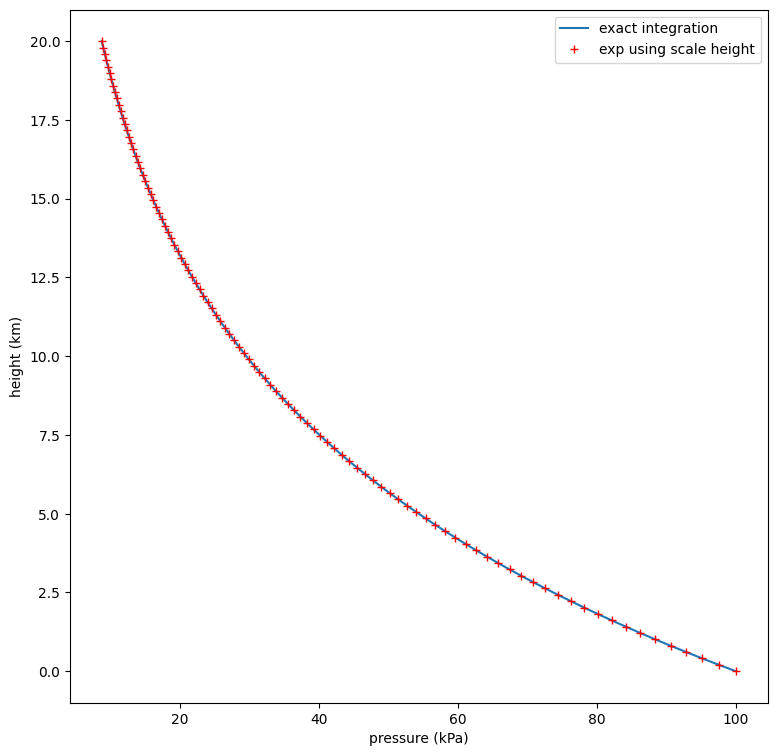

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

def function_H(Temp,height):
    R_d=287.
    g=9.8
    num_temps=len(Temp)
    inv_scale_height=0
    for index in range(num_temps - 1):
        delta_z=height[index+1] - height[index]
        inv_scale_height=inv_scale_height + \
               g/(R_d*Temp[index])*delta_z
    avg_inv_scale_height=inv_scale_height/height[-1]
    avg_scale_height=1/avg_inv_scale_height
    return avg_scale_height

def function_H_vec(Temp,height):
    """
        find the average scale height
        input: Temp (K), height (m): numpy vectors (1D)
        output: scale_height (m)
    """
    R_d=287.
    g=9.8
    num_temps=len(Temp)
    function=g/(R_d*Temp[:-1])
    delta_z=np.diff(height)
    the_int=np.sum(function*delta_z)
    the_avg=the_int/height[-1]
    scale_height=1./the_avg
    return scale_height

def press_int(heights,Temp,p0):
    """
        integrate the hydrostatic equation
        to get log pressure, then take exp
        to get pressure
    """
    Rd=287.
    g=9.8
    dz=np.diff(heights)
    function= -g/(Rd*Temp[:-1])
    log_p_p0=np.cumsum(function*dz)
    p_p0=np.exp(log_p_p0)
    p_p0=np.concatenate(([1.],p_p0))
    press_vec=p0*p_p0
    return press_vec

if __name__=="__main__":
    ztop=2.e4
    p0=1.e5
    T0=280.
    heights=np.linspace(0,ztop,100) # Changed 100. to 100
    Temp=  T0 -7.e-3*heights
    Temp=np.empty_like(heights)
    Temp[:]=T0
    press_vec=press_int(heights,Temp,p0)
    scale_height=function_H(Temp,heights)
    scale_height_II=function_H_vec(Temp,heights)
    press_scale=p0*np.exp(-heights/scale_height)
    plt.close('all')
    fig=plt.figure(1,figsize=(9,9))
    ax=fig.add_subplot(111)
    ax.plot(press_vec*1.e-3,heights*1.e-3,label='exact integration')
    ax.plot(press_scale*1.e-3,heights*1.e-3,'r+',label='exp using scale height')
    ax.set_xlabel('pressure (kPa)')
    ax.set_ylabel('height (km)')
    ax.legend(loc='best')
    plt.show()
